In [2]:

# 📥 Load real Swiss Post data with simulated performance issues
import pandas as pd

df = pd.read_csv("data4day_with_issues.csv")
df["HOUR_TIME"] = pd.to_datetime(df["HOUR_TIME"])
df["HOUR"] = df["HOUR_TIME"].dt.hour
df.head()


,HOUR_TIME,CODS_ZENT_NR,CHUTE,ZIP_CODE,PACKAGE_COUNT,AVG_PROCESSING_TIME_MINUTES,HOUR
0,2025-03-18 18:00:00,2,R0101,800500,14,1.086905,18
1,2025-03-18 18:00:00,2,R0101,800600,3,0.472222,18
2,2025-03-18 18:00:00,2,R0101,800800,6,1.625000,18
3,2025-03-18 18:00:00,2,R0101,803200,10,1.545000,18
4,2025-03-18 18:00:00,2,R0101,803700,4,1.662500,18


In [3]:

# 📊 Summarize chute-level stats
summary = (
    df.groupby(["CHUTE", "HOUR"])
    .agg(
        CHUTE_LOAD=("PACKAGE_COUNT", "sum"),
        ZIP_COUNT=("ZIP_CODE", "nunique"),
        AVG_DELAY=("AVG_PROCESSING_TIME_MINUTES", "mean")
    )
    .reset_index()
)

max_load = summary["CHUTE_LOAD"].max()
summary["CHUTE_LOAD_NORM"] = summary["CHUTE_LOAD"] / max_load * 2
summary.head()


,CHUTE,HOUR,CHUTE_LOAD,ZIP_COUNT,AVG_DELAY,CHUTE_LOAD_NORM
0,R0101,0,15,15,2.888889,0.020013
1,R0101,1,16,15,2.871667,0.021348
2,R0101,2,29,29,7.474138,0.038692
3,R0101,7,772,315,1.917245,1.030020
4,R0101,8,1273,499,1.872326,1.698466


In [4]:

# 🧠 Prepare states for RL environment
sim_states = []
for _, row in summary.iterrows():
    sim_states.append({
        "chute": row["CHUTE"],
        "hour": int(row["HOUR"]),
        "load": float(row["CHUTE_LOAD_NORM"]),
        "zip_count": int(row["ZIP_COUNT"]),
        "avg_delay": float(row["AVG_DELAY"])
    })


In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import pandas as pd
from collections import deque
import seaborn as sns


In [6]:

class PackagingCenterEnv(gym.Env):
    """
    Enhanced Packaging Center Environment with realistic contention simulation
    """
    def __init__(self, max_chutes=5, peak_hours=[9, 12, 17], holiday_mode=False):
        super(PackagingCenterEnv, self).__init__()
        
        # Environment parameters
        self.max_chutes = max_chutes
        self.peak_hours = peak_hours
        self.holiday_mode = holiday_mode
        self.current_step = 0
        self.max_steps = 100
        
        # State: [chute_load, hour_of_day, day_of_week, active_chutes, queue_length, processing_rate]
        self.observation_space = spaces.Box(
            low=np.array([0.0, 0.0, 0.0, 1.0, 0.0, 0.1]),
            high=np.array([2.0, 23.0, 6.0, float(max_chutes), 100.0, 2.0]),
            dtype=np.float32
        )
        
        # Actions: 0=nothing, 1=add_chute, 2=reroute_packages, 3=priority_processing
        self.action_space = spaces.Discrete(4)
        
        # Initialize tracking first
        self.history = {
            'load': [],
            'queue': [],
            'throughput': [],
            'delays': [],
            'actions': [],
            'rewards': []
        }
        
        # Initialize state
        self.reset()
    
    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            
        self.current_step = 0
        self.current_hour = np.random.randint(0, 24)
        self.current_day = np.random.randint(0, 7)
        self.active_chutes = 2
        self.queue_length = np.random.uniform(5, 15)
        self.processing_rate = 1.0
        self.chute_load = np.random.uniform(0.3, 0.7)
        
        # Clear history
        for key in self.history:
            self.history[key].clear()
            
        self.state = np.array([
            self.chute_load,
            self.current_hour,
            self.current_day,
            self.active_chutes,
            self.queue_length,
            self.processing_rate
        ], dtype=np.float32)
        
        return self.state, {}
    
    def _get_demand_multiplier(self):
        """Calculate demand based on time patterns"""
        base_demand = 1.0
        
        # Peak hours
        if self.current_hour in self.peak_hours:
            base_demand *= 1.5
        
        # Weekend reduction
        if self.current_day in [5, 6]:  # Saturday, Sunday
            base_demand *= 0.7
        
        # Holiday surge
        if self.holiday_mode:
            base_demand *= 2.0
            
        # Random variation
        base_demand *= np.random.uniform(0.8, 1.2)
        
        return base_demand
    
    def step(self, action):
        self.current_step += 1
        old_load = self.chute_load
        
        # Get current demand
        demand_mult = self._get_demand_multiplier()
        incoming_packages = np.random.poisson(10 * demand_mult)
        
        # Apply action
        action_cost = 0
        if action == 1:  # Add chute
            if self.active_chutes < self.max_chutes:
                self.active_chutes += 1
                action_cost = 5  # Cost of activating chute
        elif action == 2:  # Reroute packages
            self.queue_length *= 0.8  # Reduce queue by rerouting
            action_cost = 2
        elif action == 3:  # Priority processing
            self.processing_rate = min(2.0, self.processing_rate * 1.3)
            action_cost = 3
        
        # Process packages
        processed = min(
            self.queue_length,
            self.active_chutes * self.processing_rate * 8  # packages per chute per hour
        )
        
        # Update queue and load
        self.queue_length = max(0, self.queue_length - processed + incoming_packages)
        self.chute_load = min(2.0, self.queue_length / (self.active_chutes * 20))
        
        # Calculate delays and throughput
        avg_delay = self.chute_load * (2.0 if self.chute_load > 1.0 else 1.0)
        throughput = processed / max(1, incoming_packages)
        
        # Calculate reward
        reward = 0
        # Penalize high chute load
        if self.chute_load > 1.0:
            reward -= (self.chute_load - 1.0) * 10
        # Encourage action diversity
        if action == 0:  # Do Nothing
            reward -= 1
        elif action == 1:  # Add Chute
            reward += 1 if self.queue_length > 30 else -1
        elif action == 2:  # Reroute Packages
            reward += 2 if self.queue_length > 20 else -0.5
        
        # Throughput reward
        reward += throughput * 10
        
        # Delay penalty
        reward -= avg_delay * 5
        
        # Queue management
        if self.queue_length > 50:
            reward -= 10  # Heavy penalty for long queues
        
        # Load balancing
        if 0.4 <= self.chute_load <= 0.8:
            reward += 5  # Reward for optimal load
        
        # Action cost
        reward -= action_cost
        
        # Efficiency bonus
        if self.chute_load < old_load and action != 0:
            reward += 3  # Reward for effective actions
        
        # Update processing rate (decay over time)
        self.processing_rate = max(0.5, self.processing_rate * 0.95)
        
        # Time progression
        self.current_hour = (self.current_hour + 1) % 24
        if self.current_hour == 0:
            self.current_day = (self.current_day + 1) % 7
        
        # Update state
        self.state = np.array([
            self.chute_load,
            self.current_hour,
            self.current_day,
            self.active_chutes,
            self.queue_length,
            self.processing_rate
        ], dtype=np.float32)
        
        # Track history
        self.history['load'].append(self.chute_load)
        self.history['queue'].append(self.queue_length)
        self.history['throughput'].append(throughput)
        self.history['delays'].append(avg_delay)
        self.history['actions'].append(action)
        self.history['rewards'].append(reward)
        
        done = self.current_step >= self.max_steps
        truncated = False
        
        return self.state, reward, done, truncated, {
            'delay': avg_delay,
            'throughput': throughput,
            'queue_length': self.queue_length
        }


In [7]:

from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        if self.locals.get("dones", [False])[0]:
            reward = sum(self.locals["infos"][0].get("episode", {}).get("r", [0]))
            self.episode_rewards.append(reward)
            self.episode_lengths.append(self.num_timesteps)
        return True

reward_logger = RewardLoggerCallback()


In [8]:

class TrainingCallback(BaseCallback):
    """Callback to track training progress"""
    def __init__(self, verbose=0):
        super(TrainingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_episode_reward = 0
        
    def _on_step(self) -> bool:
        # Track rewards
        if 'rewards' in self.locals:
            self.current_episode_reward += self.locals['rewards'][0]
        
        # Check if episode is done
        if self.locals.get('dones', [False])[0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
        
        return True

def run_simulation(total_timesteps=10000, test_episodes=5):
    """Run the complete simulation"""
    print("🏭 Starting Packaging Center Contention Simulation")
    base_env = PackagingCenterEnv(max_chutes=5, peak_hours=[9, 12, 17])
    vec_env = DummyVecEnv([lambda: base_env])
    print("=" * 50)
    
    # Create environment
    
    # Create and train model
    print("🤖 Training RL Agent...")
    model = DQN(
        "MlpPolicy", 
        vec_env, 
        verbose=1,
        learning_rate=0.001,
        buffer_size=10000,
        learning_starts=1000,
        batch_size=32,
        target_update_interval=100,
        exploration_fraction=0.3,
        exploration_final_eps=0.05
    )
    
    callback = TrainingCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    print("✅ Training completed!")
    
    # Test the trained model
    print(f"\n🧪 Testing trained model for {test_episodes} episodes...")
    
    test_results = []
    for episode in range(test_episodes):
        obs = vec_env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        done = False
        episode_reward = 0
        step_count = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            step_result = vec_env.step(action)
            obs, reward, done = step_result[0], step_result[1], step_result[2]
            
            # Extract scalar reward value
            if isinstance(reward, (list, tuple, np.ndarray)):
                reward_val = float(reward[0])
            else:
                reward_val = float(reward)
            
            episode_reward += reward_val
            step_count += 1
            
        # Ensure episode_reward is a scalar
        episode_reward = float(episode_reward)
        
        test_results.append({
            'episode': episode + 1,
            'total_reward': episode_reward,
            'steps': step_count,
            'avg_reward_per_step': episode_reward / step_count
        })
        
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {step_count}")
        # ✅ Manual simulation for tracking history
        obs = base_env.reset()[0]
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = base_env.step(action)
    
    # Create comprehensive visualization
    create_visualization(base_env, test_results)
    
    return model, base_env, test_results

🏭 Starting Packaging Center Contention Simulation
🤖 Training RL Agent...
Using cpu device


c:\Users\mansourmoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\mansourmoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.873    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3879     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.747    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4421     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 1555     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss           

c:\Users\mansourmoa\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


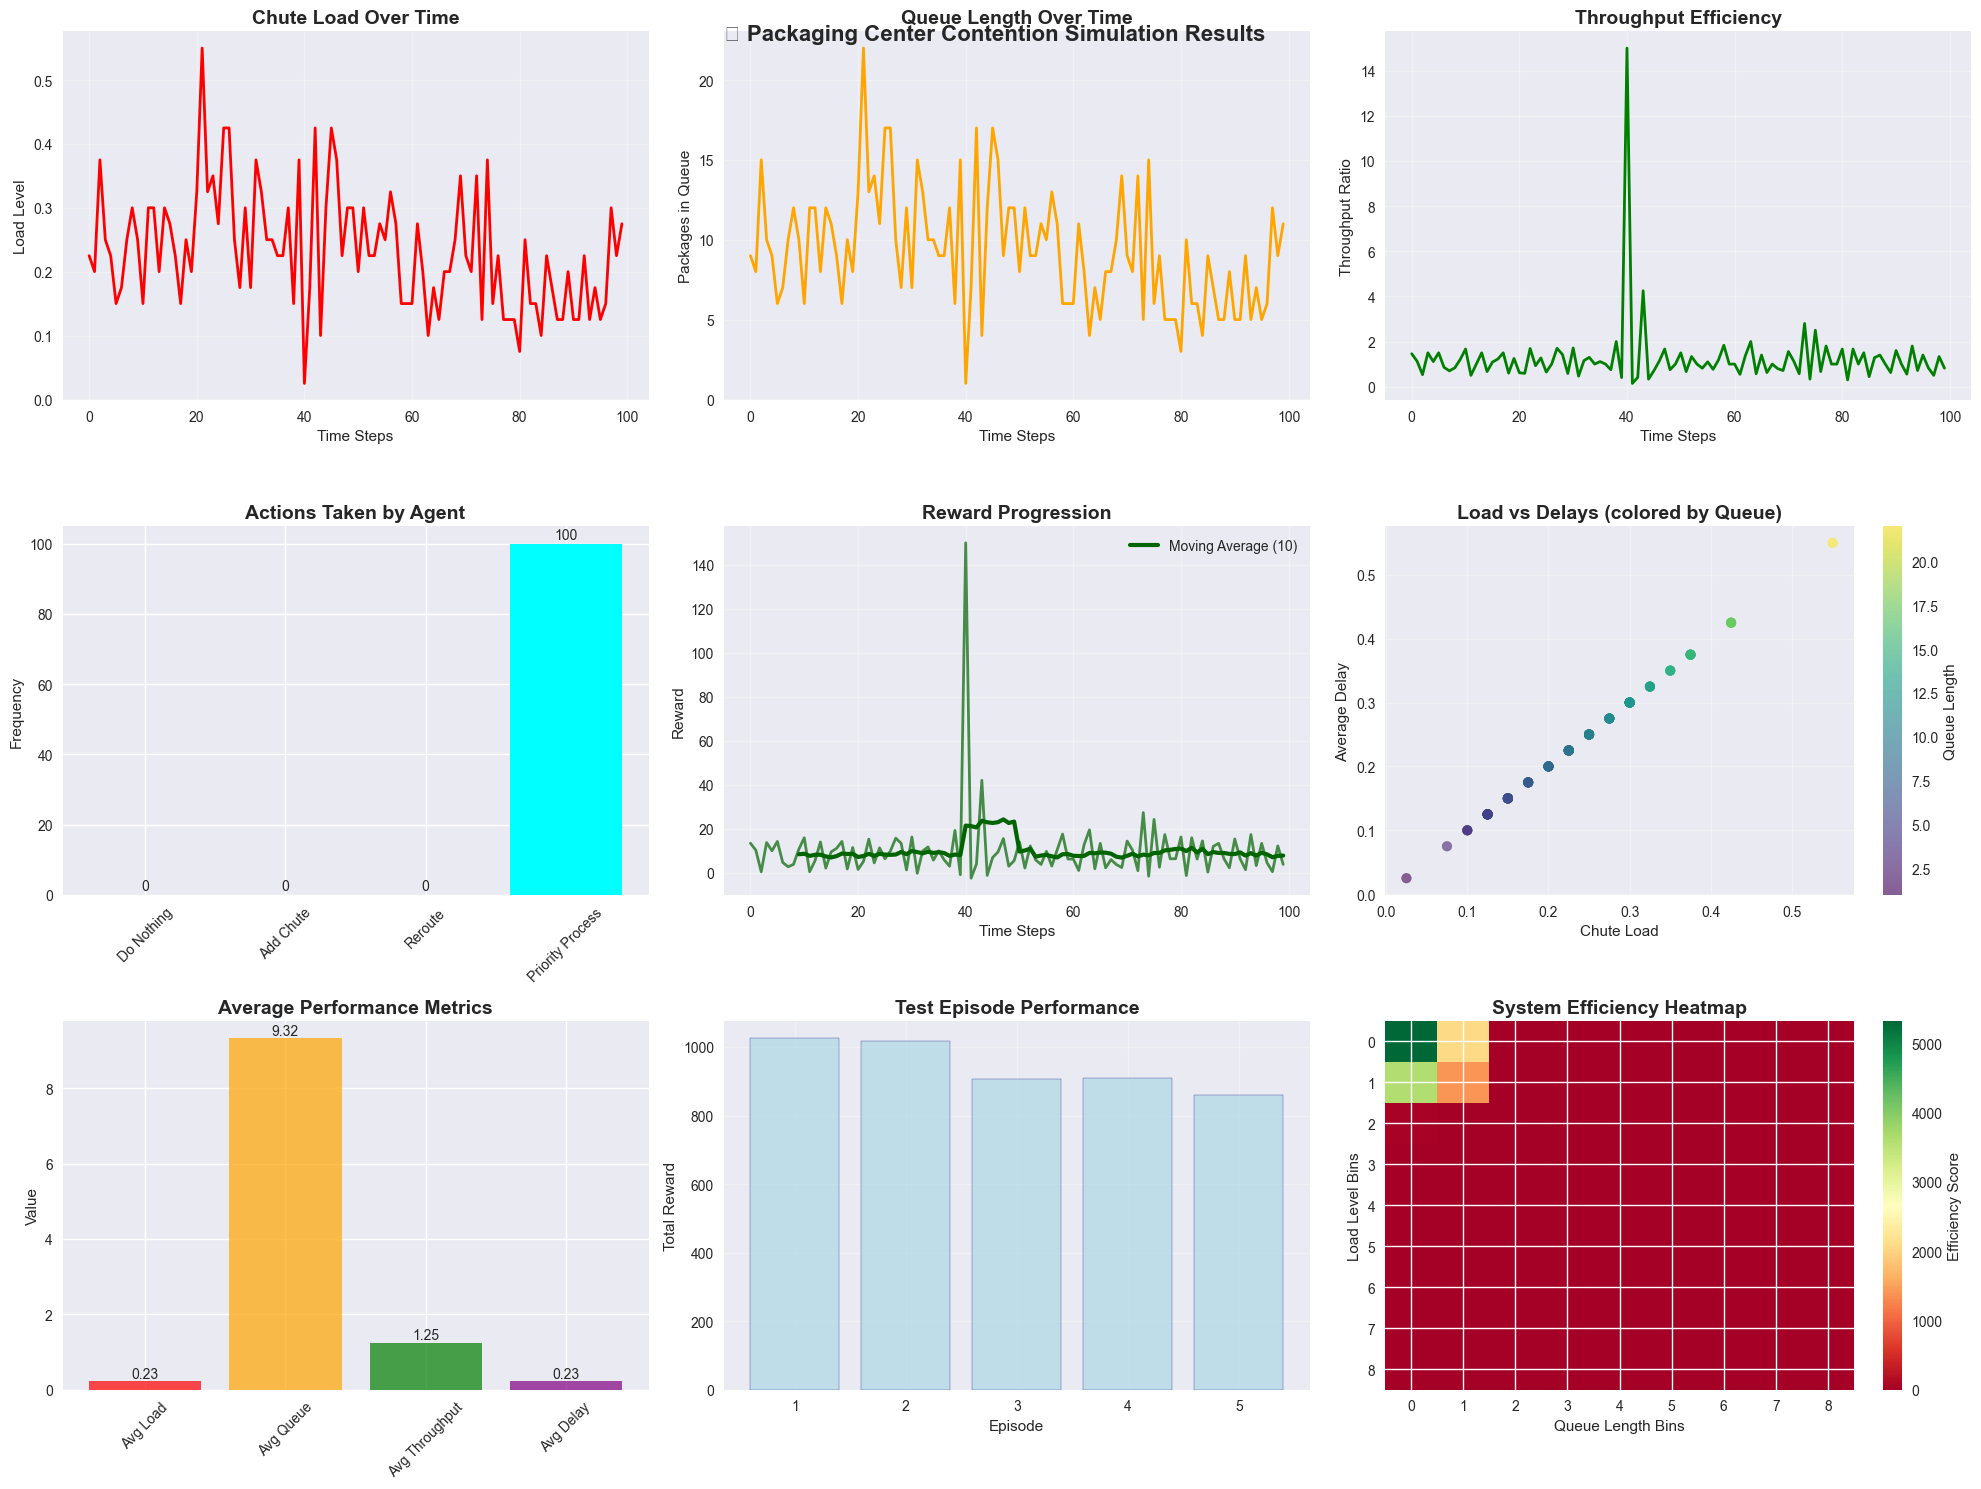


📊 SIMULATION SUMMARY
Total Steps Simulated: 100
Average Load Level: 0.233
Average Queue Length: 9.3 packages
Average Throughput: 1.246
Average Delay: 0.233 hours
Total Reward Earned: 995.42
Peak Load Reached: 0.550
Maximum Queue Length: 22.0 packages

Agent Action Distribution:
  Do Nothing: 0 times (0.0%)
  Add Chute: 0 times (0.0%)
  Reroute Packages: 0 times (0.0%)
  Priority Processing: 100 times (100.0%)

🎉 Simulation completed successfully!
Check the visualizations above for detailed analysis.


In [9]:

def create_visualization(base_env, test_results):
    """Create comprehensive visualization of results"""
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 15))
    
    # Check if we have history data
    has_history = len(base_env.history['load']) > 0
    
    if has_history:
        # 1. Load vs Time
        ax1 = plt.subplot(3, 3, 1)
        plt.plot(base_env.history['load'], color='red', linewidth=2)
        plt.title('Chute Load Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Level')
        plt.grid(True, alpha=0.3)
        
        # 2. Queue Length
        ax2 = plt.subplot(3, 3, 2)
        plt.plot(base_env.history['queue'], color='orange', linewidth=2)
        plt.title('Queue Length Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Packages in Queue')
        plt.grid(True, alpha=0.3)
        
        # 3. Throughput
        ax3 = plt.subplot(3, 3, 3)
        plt.plot(base_env.history['throughput'], color='green', linewidth=2)
        plt.title('Throughput Efficiency', fontsize=14, fontweight='bold')
        plt.xlabel('Time Steps')
        plt.ylabel('Throughput Ratio')
        plt.grid(True, alpha=0.3)
        
        # 4. Actions taken
        ax4 = plt.subplot(3, 3, 4)
        action_names = ['Do Nothing', 'Add Chute', 'Reroute', 'Priority Process']
        action_counts = [base_env.history['actions'].count(i) for i in range(4)]
        bars = plt.bar(action_names, action_counts, color=['gray', 'blue', 'purple', 'cyan'])
        plt.title('Actions Taken by Agent', fontsize=14, fontweight='bold')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, count in zip(bars, action_counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom')
    else:
        # Create placeholder plots when no history is available
        for i in range(1, 5):
            ax = plt.subplot(3, 3, i)
            plt.text(0.5, 0.5, 'No Training History\nAvailable', 
                    ha='center', va='center', transform=ax.transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            plt.title(['Load Over Time', 'Queue Length', 'Throughput', 'Actions'][i-1], 
                     fontsize=14, fontweight='bold')
    
    # 5. Reward progression
    ax5 = plt.subplot(3, 3, 5)
    if has_history and len(base_env.history['rewards']) > 0:
        plt.plot(base_env.history['rewards'], color='darkgreen', linewidth=2, alpha=0.7)
        # Only plot moving average if we have enough data points
        if len(base_env.history['rewards']) >= 10:
            window_size = min(10, len(base_env.history['rewards']))
            moving_avg = np.convolve(base_env.history['rewards'], np.ones(window_size)/window_size, mode='valid')
            plt.plot(range(window_size-1, len(base_env.history['rewards'])), moving_avg, 
                     color='darkgreen', linewidth=3, label=f'Moving Average ({window_size})')
            plt.legend()
    else:
        plt.text(0.5, 0.5, 'No Reward History\nAvailable', 
                ha='center', va='center', transform=ax5.transAxes,
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.title('Reward Progression', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # 6. Load vs Delays scatter
    ax6 = plt.subplot(3, 3, 6)
    if has_history and len(base_env.history['load']) > 0:
        plt.scatter(base_env.history['load'], base_env.history['delays'], 
                   alpha=0.6, c=base_env.history['queue'], cmap='viridis')
        plt.colorbar(label='Queue Length')
    else:
        plt.text(0.5, 0.5, 'No History Data\nAvailable', 
                ha='center', va='center', transform=ax6.transAxes,
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.title('Load vs Delays (colored by Queue)', fontsize=14, fontweight='bold')
    plt.xlabel('Chute Load')
    plt.ylabel('Average Delay')
    plt.grid(True, alpha=0.3)
    
    # 7. Performance metrics
    ax7 = plt.subplot(3, 3, 7)
    if has_history:
        metrics = ['Avg Load', 'Avg Queue', 'Avg Throughput', 'Avg Delay']
        values = [
            np.mean(base_env.history['load']),
            np.mean(base_env.history['queue']),
            np.mean(base_env.history['throughput']),
            np.mean(base_env.history['delays'])
        ]
        colors = ['red', 'orange', 'green', 'purple']
        bars = plt.bar(metrics, values, color=colors, alpha=0.7)
        
        # Add value labels
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.2f}', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'No Performance\nData Available', 
                ha='center', va='center', transform=ax7.transAxes,
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.title('Average Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    
    # 8. Test episode results
    ax8 = plt.subplot(3, 3, 8)
    episodes = [r['episode'] for r in test_results]
    rewards = [r['total_reward'] for r in test_results]
    plt.bar(episodes, rewards, color='lightblue', edgecolor='navy', alpha=0.7)
    plt.title('Test Episode Performance', fontsize=14, fontweight='bold')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)
    
    # 9. System efficiency heatmap
    ax9 = plt.subplot(3, 3, 9)
    # Create efficiency matrix (load vs queue)
    load_bins = np.linspace(0, 2, 10)
    queue_bins = np.linspace(0, 100, 10)
    efficiency_matrix = np.zeros((len(load_bins)-1, len(queue_bins)-1))
    
    for i, load in enumerate(base_env.history['load']):
        for j, queue in enumerate(base_env.history['queue']):
            load_idx = np.digitize(load, load_bins) - 1
            queue_idx = np.digitize(queue, queue_bins) - 1
            if 0 <= load_idx < len(load_bins)-1 and 0 <= queue_idx < len(queue_bins)-1:
                efficiency_matrix[load_idx, queue_idx] += base_env.history['throughput'][i] if i < len(base_env.history['throughput']) else 0
    
    im = plt.imshow(efficiency_matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, label='Efficiency Score')
    plt.title('System Efficiency Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Queue Length Bins')
    plt.ylabel('Load Level Bins')
    
    plt.tight_layout()
    plt.suptitle('🏭 Packaging Center Contention Simulation Results', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Print summary statistics
    print("\n📊 SIMULATION SUMMARY")
    print("=" * 50)
    
    # Check if we have history data
    if len(base_env.history['load']) > 0:
        print(f"Total Steps Simulated: {len(base_env.history['load'])}")
        print(f"Average Load Level: {np.mean(base_env.history['load']):.3f}")
        print(f"Average Queue Length: {np.mean(base_env.history['queue']):.1f} packages")
        print(f"Average Throughput: {np.mean(base_env.history['throughput']):.3f}")
        print(f"Average Delay: {np.mean(base_env.history['delays']):.3f} hours")
        print(f"Total Reward Earned: {np.sum(base_env.history['rewards']):.2f}")
        print(f"Peak Load Reached: {np.max(base_env.history['load']):.3f}")
        print(f"Maximum Queue Length: {np.max(base_env.history['queue']):.1f} packages")
        
        action_summary = {
            0: "Do Nothing",
            1: "Add Chute", 
            2: "Reroute Packages",
            3: "Priority Processing"
        }
        
        print("\nAgent Action Distribution:")
        for action, count in enumerate([base_env.history['actions'].count(i) for i in range(4)]):
            percentage = (count / len(base_env.history['actions'])) * 100 if len(base_env.history['actions']) > 0 else 0
            print(f"  {action_summary[action]}: {count} times ({percentage:.1f}%)")
    else:
        print("No simulation history available - this may be due to using vectorized environment.")
        print("Summary from test episodes:")
        if test_results:
            avg_reward = np.mean([r['total_reward'] for r in test_results])
            avg_steps = np.mean([r['steps'] for r in test_results])
            print(f"Average Episode Reward: {avg_reward:.2f}")
            print(f"Average Episode Length: {avg_steps:.1f} steps")
            print(f"Test Episodes Completed: {len(test_results)}")

if __name__ == "__main__":
    # Run the simulation
    model, env, results = run_simulation(total_timesteps=10000, test_episodes=5)
    
    print("\n🎉 Simulation completed successfully!")
    print("Check the visualizations above for detailed analysis.")